# **Import Library**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd

# Load dataset
file_path = 'Balanced_Household_Transactions.xlsx'
df = pd.read_excel(file_path)

# Separate features and target variable
X = df.drop(columns=['Category'])
y = df['Category']

# Check the distribution of your target variable 'Category'
print(y.value_counts())

Category
FOOD              597
HEALTH            597
OTHER             597
DRINKS            597
FOOD & DINING     597
HOUSEHOLD         597
TRANSPORTATION    597
GROCERIES         597
FAMILY            597
SUBSCRIPTION      597
APPAREL           597
EDUCATION         597
GROCERY           597
FESTIVALS         597
UTILITIES         597
BEAUTY            597
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.0720 - loss: 2.8355 - val_accuracy: 0.1256 - val_loss: 2.7439
Epoch 2/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.0902 - loss: 2.7377 - val_accuracy: 0.2171 - val_loss: 2.6556
Epoch 3/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.1234 - loss: 2.6476 - val_accuracy: 0.2021 - val_loss: 2.5167
Epoch 4/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.1879 - loss: 2.5107 - val_accuracy: 0.2956 - val_loss: 2.2604
Epoch 5/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.2525 - loss: 2.3000 - val_accuracy: 0.3466 - val_loss: 2.1045
Epoch 6/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.3023 - loss: 2.1624 - val_accuracy: 0.3741 - val_loss: 1.9648
Epoch 7/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.3453 - loss: 2.0338 - val_accuracy: 0.4218 - val_loss: 1.8658
Epoch 8/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.3778 - loss: 1.9428 - val_accurac

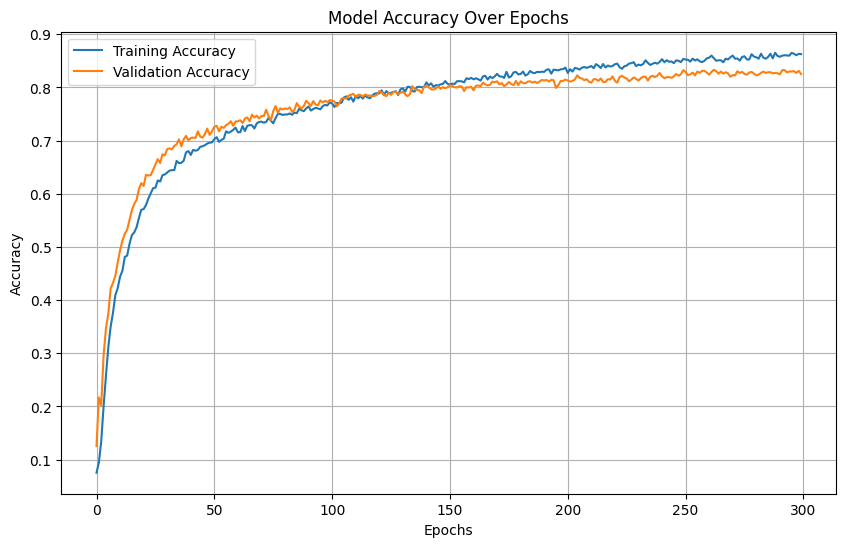

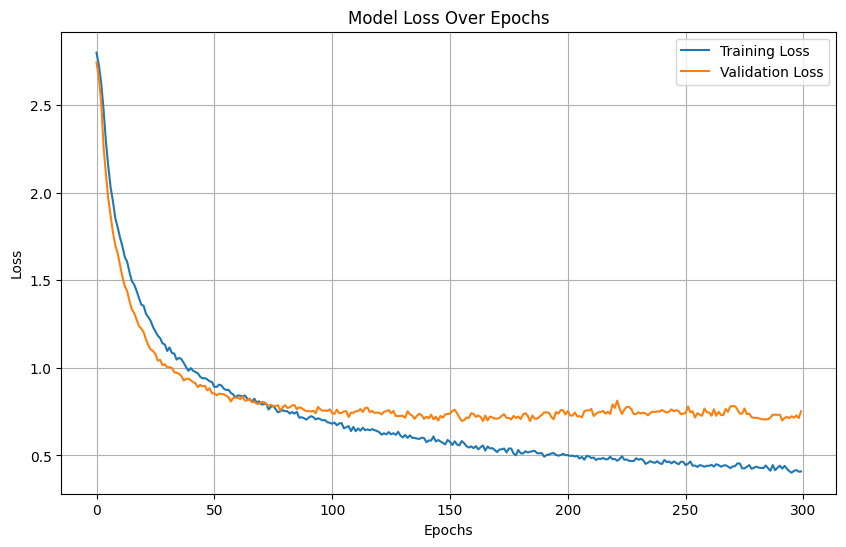

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer

# Load datasets
train_data = pd.read_excel("Training_Datasets.xlsx")
test_data = pd.read_excel("Testing_Datasets.xlsx")

# Feature Engineering
def preprocess_data_aligned(train_df, test_df):
    # Extract date components
    for df in [train_df, test_df]:
        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['DayOfWeek'] = df['Date'].dt.dayofweek

    # Transform textual features using TF-IDF
    tfidf = TfidfVectorizer(max_features=100)
    tfidf_train = tfidf.fit_transform(train_df['Noted'].fillna('')).toarray()
    tfidf_test = tfidf.transform(test_df['Noted'].fillna('')).toarray()

    tfidf_train_df = pd.DataFrame(tfidf_train, columns=[f"TFIDF_{i}" for i in range(tfidf_train.shape[1])])
    tfidf_test_df = pd.DataFrame(tfidf_test, columns=[f"TFIDF_{i}" for i in range(tfidf_test.shape[1])])

    # One-hot encode categorical columns
    categorical_train = pd.get_dummies(train_df[['Transaction Type', 'Payment Method']])
    categorical_test = pd.get_dummies(test_df[['Transaction Type', 'Payment Method']])

    # Align columns
    categorical_train, categorical_test = categorical_train.align(categorical_test, join='outer', axis=1, fill_value=0)

    # Combine features
    numerical_train = train_df[['Amount', 'Year', 'Month', 'DayOfWeek']]
    numerical_test = test_df[['Amount', 'Year', 'Month', 'DayOfWeek']]

    train_combined = pd.concat([numerical_train, categorical_train, tfidf_train_df], axis=1)
    test_combined = pd.concat([numerical_test, categorical_test, tfidf_test_df], axis=1)

    return train_combined, test_combined

# Preprocess training and testing datasets
X_train_full, X_test_full = preprocess_data_aligned(train_data, test_data)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# Encode target variable
le_category = LabelEncoder()
y_train = le_category.fit_transform(train_data['Category'])
y_test = le_category.transform(test_data['Category'])

# Convert target to one-hot encoding
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Define Neural Network
model = Sequential([
    Dense(1024, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(y_train_onehot.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_scaled, y_train_onehot,
    epochs=300,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_onehot, verbose=0)

# Print results
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.2636 - loss: 3.2669 - val_accuracy: 0.4559 - val_loss: 2.7611 - learning_rate: 0.0100
Epoch 2/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4941 - loss: 2.3024 - val_accuracy: 0.5343 - val_loss: 2.4970 - learning_rate: 0.0100
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5446 - loss: 2.0971 - val_accuracy: 0.5768 - val_loss: 2.2663 - learning_rate: 0.0100
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5792 - loss: 1.9760 - val_accuracy: 0.6128 - val_loss: 2.0779 - learning_rate: 0.0100
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6024 - loss: 1.8675 - val_accuracy: 0.6279 - val_loss: 1.9051 - learning_rate: 0.0100
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6368 - loss: 1.7801 - val_accuracy: 0.6547 - val_loss: 1.7980 - learning_rate: 0.0100
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6587 - loss: 1.7142 - 

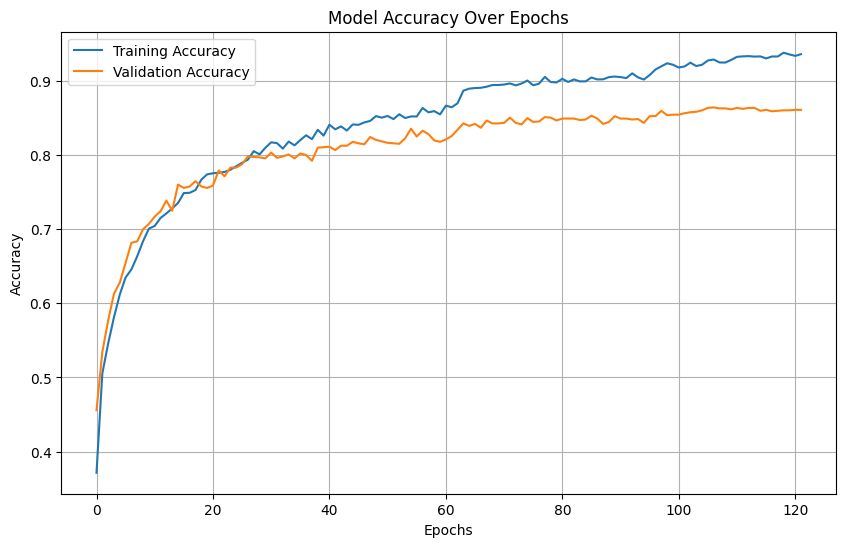

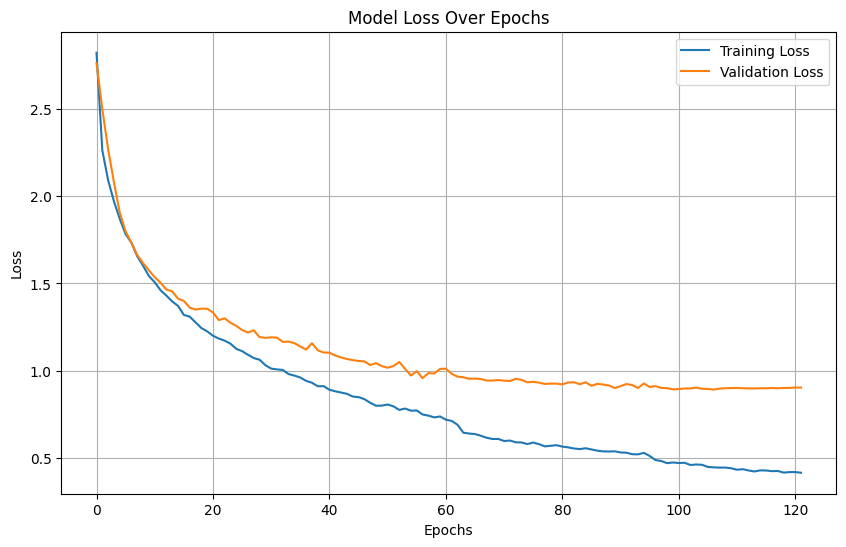

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the datasets
train_data = pd.read_excel("Training_Datasets.xlsx")
test_data = pd.read_excel("Testing_Datasets.xlsx")

# Feature Engineering
def preprocess_data_aligned(train_df, test_df):
    # Extract date components
    for df in [train_df, test_df]:
        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['DayOfWeek'] = df['Date'].dt.dayofweek

    # Transform textual features using TF-IDF
    tfidf = TfidfVectorizer(max_features=100)
    tfidf_train = tfidf.fit_transform(train_df['Noted'].fillna('')).toarray()
    tfidf_test = tfidf.transform(test_df['Noted'].fillna('')).toarray()

    tfidf_train_df = pd.DataFrame(tfidf_train, columns=[f"TFIDF_{i}" for i in range(tfidf_train.shape[1])])
    tfidf_test_df = pd.DataFrame(tfidf_test, columns=[f"TFIDF_{i}" for i in range(tfidf_test.shape[1])])

    # One-hot encode categorical columns
    categorical_train = pd.get_dummies(train_df[['Transaction Type', 'Payment Method']])
    categorical_test = pd.get_dummies(test_df[['Transaction Type', 'Payment Method']])

    # Align columns
    categorical_train, categorical_test = categorical_train.align(categorical_test, join='outer', axis=1, fill_value=0)

    # Combine features
    numerical_train = train_df[['Amount', 'Year', 'Month', 'DayOfWeek']]
    numerical_test = test_df[['Amount', 'Year', 'Month', 'DayOfWeek']]

    train_combined = pd.concat([numerical_train, categorical_train, tfidf_train_df], axis=1)
    test_combined = pd.concat([numerical_test, categorical_test, tfidf_test_df], axis=1)

    return train_combined, test_combined

# Preprocess training and testing datasets
X_train_full, X_test_full = preprocess_data_aligned(train_data, test_data)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# Encode target variable
le_category = LabelEncoder()
y_train = le_category.fit_transform(train_data['Category'])
y_test = le_category.transform(test_data['Category'])

# Convert target to one-hot encoding
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Define Neural Network with L2 regularization and simplified architecture
model = Sequential([
    Dense(512, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(y_train_onehot.shape[1], activation='softmax')
])

# Compile with SGD optimizer
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    X_train_scaled, y_train_onehot,
    epochs=300,
    batch_size=128,
    validation_split=0.2,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_onehot, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.2313 - loss: 3.7100 - val_accuracy: 0.4630 - val_loss: 2.8854 - learning_rate: 0.0030
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4483 - loss: 2.6869 - val_accuracy: 0.5245 - val_loss: 2.5473 - learning_rate: 0.0030
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4857 - loss: 2.5623 - val_accuracy: 0.5422 - val_loss: 2.3723 - learning_rate: 0.0030
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5137 - loss: 2.4306 - val_accuracy: 0.5782 - val_loss: 2.2720 - learning_rate: 0.0030
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5310 - loss: 2.3521 - val_accuracy: 0.6050 - val_loss: 2.2092 - learning_rate: 0.0030
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5547 - loss: 2.2720 - val_accuracy: 0.6141 - val_loss: 2.1364 - learning_rate: 0.0030
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5671 - loss: 2.2046 - val_accuracy

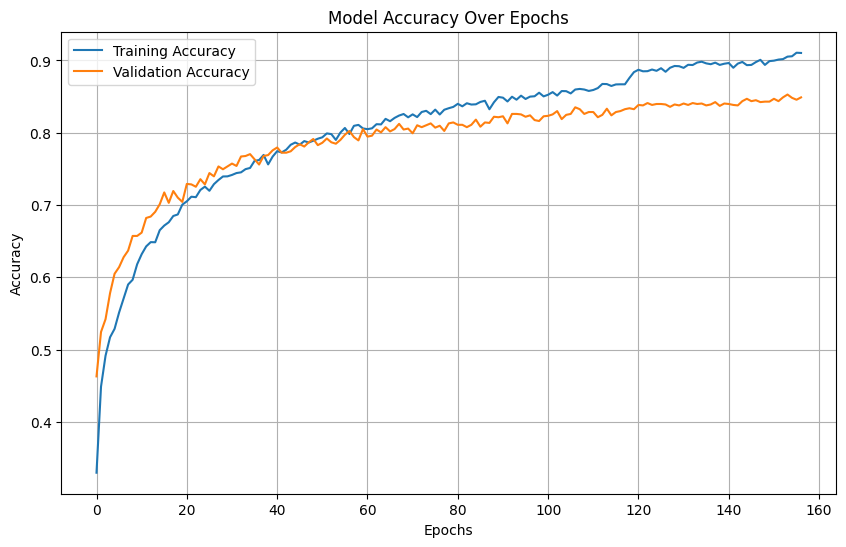

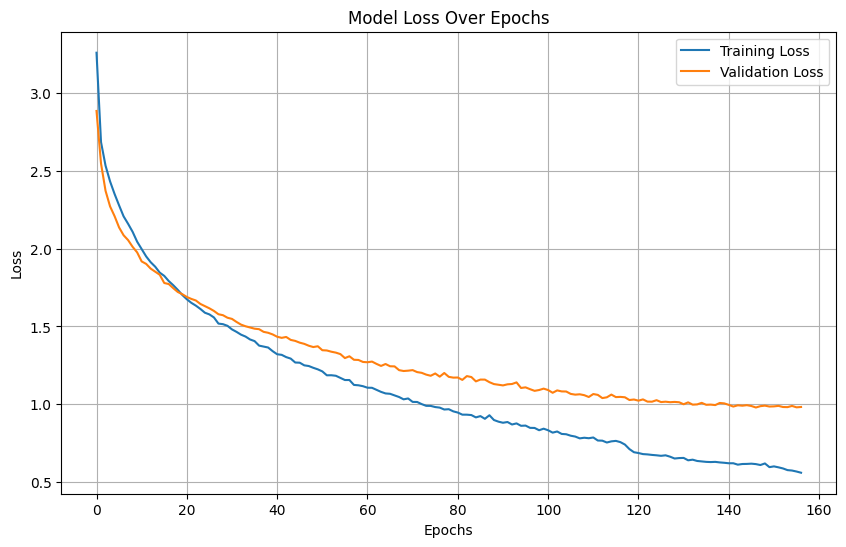

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ActivityRegularization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the datasets
train_data = pd.read_excel("Training_Datasets.xlsx")
test_data = pd.read_excel("Testing_Datasets.xlsx")

# Feature Engineering
def preprocess_data_aligned(train_df, test_df):
    # Extract date components
    for df in [train_df, test_df]:
        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['DayOfWeek'] = df['Date'].dt.dayofweek

    # Transform textual features using TF-IDF
    tfidf = TfidfVectorizer(max_features=100)
    tfidf_train = tfidf.fit_transform(train_df['Noted'].fillna('')).toarray()
    tfidf_test = tfidf.transform(test_df['Noted'].fillna('')).toarray()

    tfidf_train_df = pd.DataFrame(tfidf_train, columns=[f"TFIDF_{i}" for i in range(tfidf_train.shape[1])])
    tfidf_test_df = pd.DataFrame(tfidf_test, columns=[f"TFIDF_{i}" for i in range(tfidf_test.shape[1])])

    # One-hot encode categorical columns
    categorical_train = pd.get_dummies(train_df[['Transaction Type', 'Payment Method']])
    categorical_test = pd.get_dummies(test_df[['Transaction Type', 'Payment Method']])

    # Align columns
    categorical_train, categorical_test = categorical_train.align(categorical_test, join='outer', axis=1, fill_value=0)

    # Combine features
    numerical_train = train_df[['Amount', 'Year', 'Month', 'DayOfWeek']]
    numerical_test = test_df[['Amount', 'Year', 'Month', 'DayOfWeek']]

    train_combined = pd.concat([numerical_train, categorical_train, tfidf_train_df], axis=1)
    test_combined = pd.concat([numerical_test, categorical_test, tfidf_test_df], axis=1)

    return train_combined, test_combined

# Preprocess training and testing datasets
X_train_full, X_test_full = preprocess_data_aligned(train_data, test_data)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# Encode target variable
le_category = LabelEncoder()
y_train = le_category.fit_transform(train_data['Category'])
y_test = le_category.transform(test_data['Category'])

# Convert target to one-hot encoding
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Define Neural Network with L2 and Activity Regularization
model = Sequential([
    Dense(640, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.15),
    Dense(320, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    ActivityRegularization(l1=1e-6, l2=1e-6),  # Encourage smaller activation magnitudes
    Dense(y_train_onehot.shape[1], activation='softmax')
])

# Compile the model
sgd = SGD(learning_rate=0.003, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    X_train_scaled, y_train_onehot,
    epochs=200,
    batch_size=64,
    validation_split=0.2,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_onehot, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.2179 - loss: 4.0285 - val_accuracy: 0.5536 - val_loss: 2.7662
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4987 - loss: 2.8282 - val_accuracy: 0.6077 - val_loss: 2.4155
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5727 - loss: 2.5415 - val_accuracy: 0.6321 - val_loss: 2.2659
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6027 - loss: 2.3928 - val_accuracy: 0.6774 - val_loss: 2.1151
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6256 - loss: 2.2691 - val_accuracy: 0.6757 - val_loss: 2.0326
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6466 - loss: 2.1566 - val_accuracy: 0.6940 - val_loss: 1.9781
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6646 - loss: 2.0672 - val_accuracy: 0.7193 - val_loss: 1.8881
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6865 - loss: 1.9921 - 

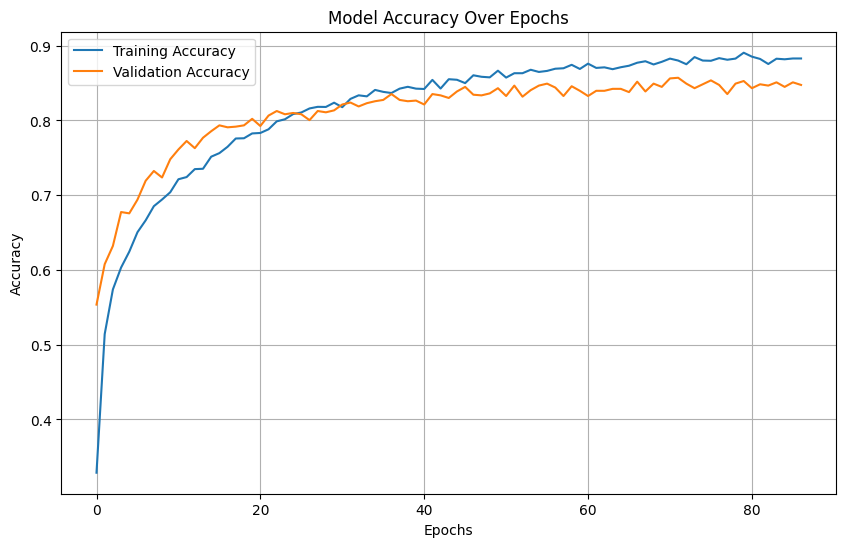

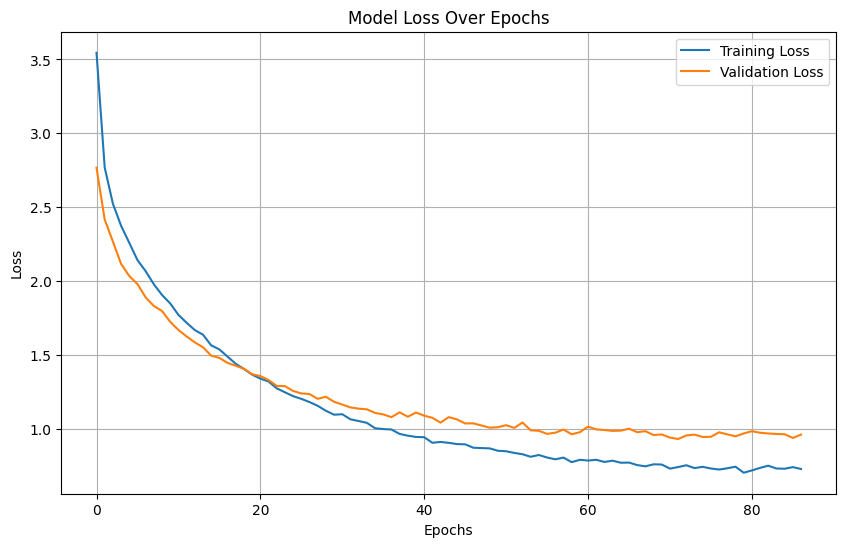

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import math

# Load the datasets
train_data = pd.read_excel("Training_Datasets.xlsx")
test_data = pd.read_excel("Testing_Datasets.xlsx")

# Enhanced preprocessing function
def preprocess_data(train_df, test_df):
    for df in [train_df, test_df]:
        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

    tfidf = TfidfVectorizer(max_features=300)
    tfidf_train = tfidf.fit_transform(train_df['Noted'].fillna('')).toarray()
    tfidf_test = tfidf.transform(test_df['Noted'].fillna('')).toarray()

    tfidf_train_df = pd.DataFrame(tfidf_train, columns=[f"TFIDF_{i}" for i in range(tfidf_train.shape[1])])
    tfidf_test_df = pd.DataFrame(tfidf_test, columns=[f"TFIDF_{i}" for i in range(tfidf_test.shape[1])])

    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    categorical_train = ohe.fit_transform(train_df[['Transaction Type', 'Payment Method', 'Location']])
    categorical_test = ohe.transform(test_df[['Transaction Type', 'Payment Method', 'Location']])

    categorical_columns = ohe.get_feature_names_out(['Transaction Type', 'Payment Method', 'Location'])
    categorical_train_df = pd.DataFrame(categorical_train, columns=categorical_columns)
    categorical_test_df = pd.DataFrame(categorical_test, columns=categorical_columns)

    numerical_features = ['Amount', 'Year', 'Month', 'DayOfWeek', 'IsWeekend']
    numerical_train = train_df[numerical_features]
    numerical_test = test_df[numerical_features]

    train_combined = pd.concat([numerical_train, categorical_train_df, tfidf_train_df], axis=1)
    test_combined = pd.concat([numerical_test, categorical_test_df, tfidf_test_df], axis=1)

    return train_combined, test_combined

# Preprocess the datasets
X_train_full, X_test_full = preprocess_data(train_data, test_data)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# Encode the target variable
le_category = LabelEncoder()
y_train = le_category.fit_transform(train_data['Category'])
y_test = le_category.transform(test_data['Category'])

y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)

# Define the updated model
model = Sequential([
    Dense(640, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(320, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(160, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(80, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(y_train_onehot.shape[1], activation='softmax')
])

# Compile the model with SGD optimizer
model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    X_train_scaled, y_train_onehot,
    epochs=100,
    batch_size=64,
    validation_split=0.15,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_onehot, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.1430 - loss: 4.8331 - val_accuracy: 0.4821 - val_loss: 3.6220 - learning_rate: 0.0010
Epoch 2/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.4087 - loss: 3.6779 - val_accuracy: 0.5527 - val_loss: 3.0520 - learning_rate: 0.0010
Epoch 3/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.5193 - loss: 3.2197 - val_accuracy: 0.6129 - val_loss: 2.8413 - learning_rate: 0.0010
Epoch 4/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5518 - loss: 3.0080 - val_accuracy: 0.6452 - val_loss: 2.6448 - learning_rate: 0.0010
Epoch 5/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5920 - loss: 2.8094 - val_accuracy: 0.6713 - val_loss: 2.5001 - learning_rate: 0.0010
Epoch 6/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6163 - loss: 2.6383 - val_accuracy: 0.6861 - val_loss: 2.3692 - learning_rate: 0.0010
Epoch 7/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6538 - l

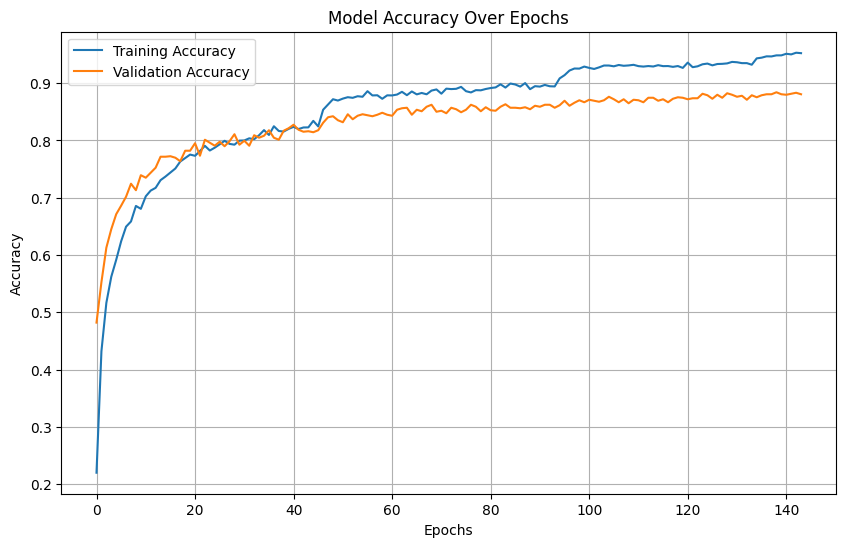

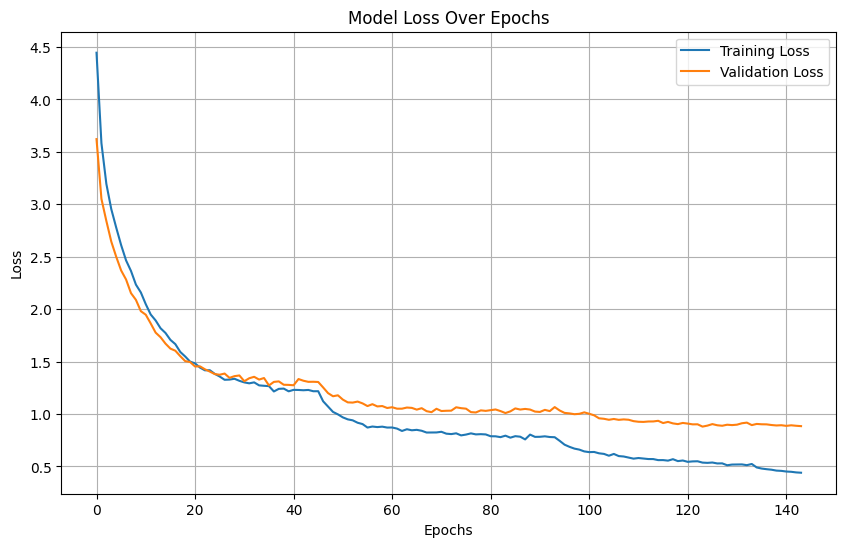

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the datasets
train_data = pd.read_excel("Training_Datasets.xlsx")
test_data = pd.read_excel("Testing_Datasets.xlsx")

# Enhanced preprocessing function
def preprocess_data(train_df, test_df):
    for df in [train_df, test_df]:
        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

    tfidf = TfidfVectorizer(max_features=300)
    tfidf_train = tfidf.fit_transform(train_df['Noted'].fillna('')).toarray()
    tfidf_test = tfidf.transform(test_df['Noted'].fillna('')).toarray()

    tfidf_train_df = pd.DataFrame(tfidf_train, columns=[f"TFIDF_{i}" for i in range(tfidf_train.shape[1])])
    tfidf_test_df = pd.DataFrame(tfidf_test, columns=[f"TFIDF_{i}" for i in range(tfidf_test.shape[1])])

    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    categorical_train = ohe.fit_transform(train_df[['Transaction Type', 'Payment Method', 'Location']])
    categorical_test = ohe.transform(test_df[['Transaction Type', 'Payment Method', 'Location']])

    categorical_columns = ohe.get_feature_names_out(['Transaction Type', 'Payment Method', 'Location'])
    categorical_train_df = pd.DataFrame(categorical_train, columns=categorical_columns)
    categorical_test_df = pd.DataFrame(categorical_test, columns=categorical_columns)

    numerical_features = ['Amount', 'Year', 'Month', 'DayOfWeek', 'IsWeekend']
    numerical_train = train_df[numerical_features]
    numerical_test = test_df[numerical_features]

    train_combined = pd.concat([numerical_train, categorical_train_df, tfidf_train_df], axis=1)
    test_combined = pd.concat([numerical_test, categorical_test_df, tfidf_test_df], axis=1)

    return train_combined, test_combined

# Preprocess the datasets
X_train_full, X_test_full = preprocess_data(train_data, test_data)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# Encode the target variable
le_category = LabelEncoder()
y_train = le_category.fit_transform(train_data['Category'])
y_test = le_category.transform(test_data['Category'])

y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)

# Define the updated model
model = Sequential([
    Dense(1024, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(y_train_onehot.shape[1], activation='softmax')
])

# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_scaled, y_train_onehot,
    epochs=150,
    batch_size=64,
    validation_split=0.15,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_onehot, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.1997 - loss: 5.7969 - val_accuracy: 0.5641 - val_loss: 4.7320
Epoch 2/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4764 - loss: 4.6734 - val_accuracy: 0.6242 - val_loss: 4.2315
Epoch 3/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5703 - loss: 4.2799 - val_accuracy: 0.6652 - val_loss: 3.9378
Epoch 4/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6193 - loss: 4.0038 - val_accuracy: 0.6643 - val_loss: 3.7340
Epoch 5/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6452 - loss: 3.7808 - val_accuracy: 0.6870 - val_loss: 3.5304
Epoch 6/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6722 - loss: 3.5605 - val_accuracy: 0.7001 - val_loss: 3.3527
Epoch 7/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7005 - loss: 3.3841 - val_accuracy: 0.7044 - val_loss: 3.1924
Epoch 8/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7016 - loss: 3.2269 - 

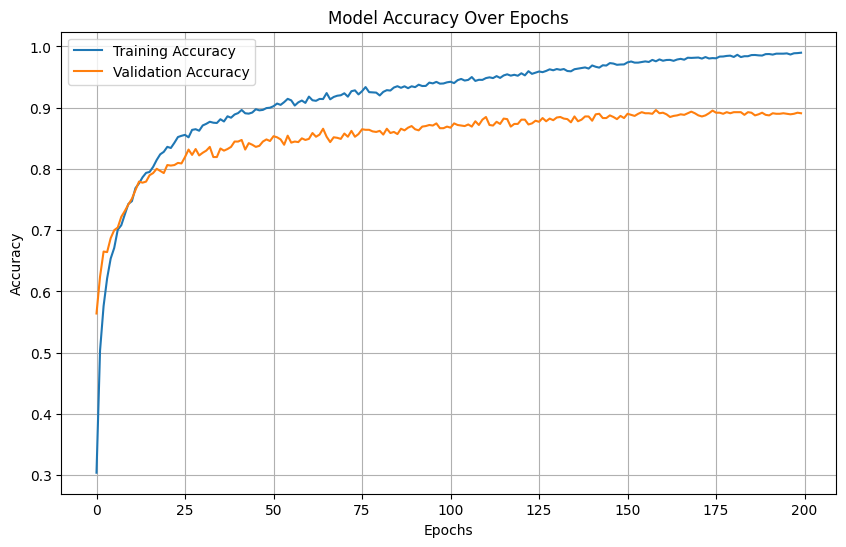

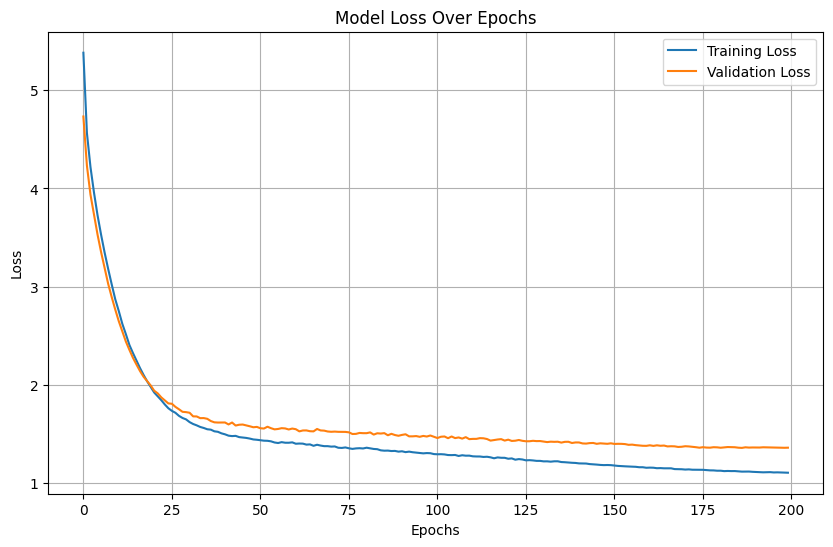

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the datasets
train_data = pd.read_excel("Training_Datasets.xlsx")
test_data = pd.read_excel("Testing_Datasets.xlsx")

# Enhanced preprocessing function
def preprocess_data(train_df, test_df):
    for df in [train_df, test_df]:
        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

    tfidf = TfidfVectorizer(max_features=300)
    tfidf_train = tfidf.fit_transform(train_df['Noted'].fillna('')).toarray()
    tfidf_test = tfidf.transform(test_df['Noted'].fillna('')).toarray()

    tfidf_train_df = pd.DataFrame(tfidf_train, columns=[f"TFIDF_{i}" for i in range(tfidf_train.shape[1])])
    tfidf_test_df = pd.DataFrame(tfidf_test, columns=[f"TFIDF_{i}" for i in range(tfidf_test.shape[1])])

    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    categorical_train = ohe.fit_transform(train_df[['Transaction Type', 'Payment Method', 'Location']])
    categorical_test = ohe.transform(test_df[['Transaction Type', 'Payment Method', 'Location']])

    categorical_columns = ohe.get_feature_names_out(['Transaction Type', 'Payment Method', 'Location'])
    categorical_train_df = pd.DataFrame(categorical_train, columns=categorical_columns)
    categorical_test_df = pd.DataFrame(categorical_test, columns=categorical_columns)

    numerical_features = ['Amount', 'Year', 'Month', 'DayOfWeek', 'IsWeekend']
    numerical_train = train_df[numerical_features]
    numerical_test = test_df[numerical_features]

    train_combined = pd.concat([numerical_train, categorical_train_df, tfidf_train_df], axis=1)
    test_combined = pd.concat([numerical_test, categorical_test_df, tfidf_test_df], axis=1)

    return train_combined, test_combined

# Preprocess the datasets
X_train_full, X_test_full = preprocess_data(train_data, test_data)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# Encode the target variable
le_category = LabelEncoder()
y_train = le_category.fit_transform(train_data['Category'])
y_test = le_category.transform(test_data['Category'])

y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)

# Adjusted Model Architecture
model = Sequential([
    Dense(512, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.003)),
    BatchNormalization(),
    Dropout(0.2),  # Reduced Dropout
    Dense(256, activation='relu', kernel_regularizer=l2(0.003)),
    BatchNormalization(),
    Dropout(0.2),  # Reduced Dropout
    Dense(128, activation='relu', kernel_regularizer=l2(0.003)),
    BatchNormalization(),
    Dropout(0.1),  # Reduced Dropout for deeper layers
    Dense(64, activation='relu', kernel_regularizer=l2(0.003)),  # Added layer
    BatchNormalization(),
    Dropout(0.1),
    Dense(y_train_onehot.shape[1], activation='softmax')
])

# Fine-Tuned Learning Rate Schedule
decay_steps = len(X_train_scaled) // 64 * 200  # Adjusted decay steps
lr_schedule = CosineDecay(
    initial_learning_rate=0.0005,  # Lower initial learning rate
    decay_steps=decay_steps,
    alpha=0.0001
)

# Compile the Model
model.compile(
    optimizer=AdamW(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),  # Slightly increased label smoothing
    metrics=['accuracy']
)

# Updated Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

# Train the Model
history = model.fit(
    X_train_scaled, y_train_onehot,
    epochs=200,  # Increased total epochs
    batch_size=64,  # Smaller batch size
    validation_split=0.15,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_onehot, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2244 - loss: 4.8202 - val_accuracy: 0.5501 - val_loss: 3.9181
Epoch 2/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5014 - loss: 3.8485 - val_accuracy: 0.6408 - val_loss: 3.5109
Epoch 3/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5661 - loss: 3.5875 - val_accuracy: 0.6609 - val_loss: 3.3034
Epoch 4/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6253 - loss: 3.3702 - val_accuracy: 0.6696 - val_loss: 3.1643
Epoch 5/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6570 - loss: 3.2159 - val_accuracy: 0.6992 - val_loss: 3.0408
Epoch 6/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6728 - loss: 3.0904 - val_accuracy: 0.7001 - val_loss: 2.9189
Epoch 7/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7054 - loss: 2.9558 - val_accuracy: 0.7341 - val_loss: 2.8136
Epoch 8/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7108 - loss: 2.8639 - val_accuracy: 0.740

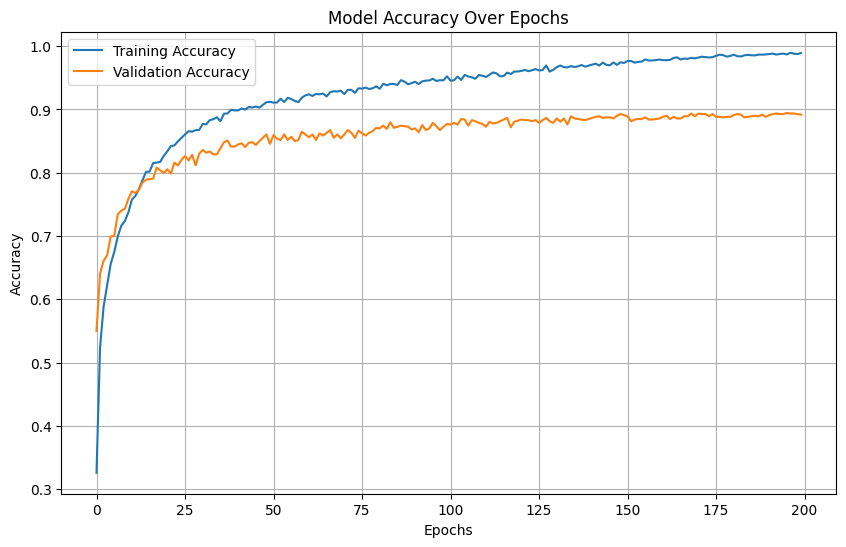

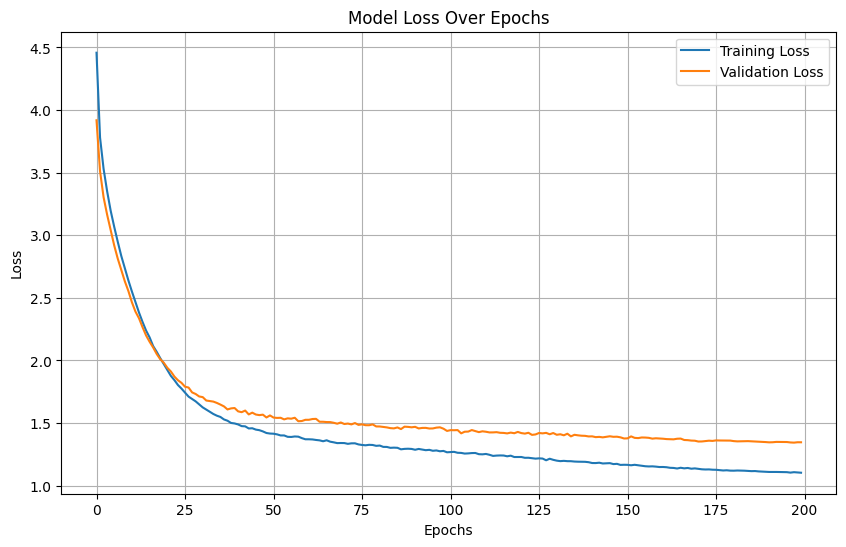

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the datasets
train_data = pd.read_excel("Training_Datasets.xlsx")
test_data = pd.read_excel("Testing_Datasets.xlsx")

# Enhanced preprocessing function
def preprocess_data(train_df, test_df):
    for df in [train_df, test_df]:
        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

    tfidf = TfidfVectorizer(max_features=300)
    tfidf_train = tfidf.fit_transform(train_df['Noted'].fillna('')).toarray()
    tfidf_test = tfidf.transform(test_df['Noted'].fillna('')).toarray()

    tfidf_train_df = pd.DataFrame(tfidf_train, columns=[f"TFIDF_{i}" for i in range(tfidf_train.shape[1])])
    tfidf_test_df = pd.DataFrame(tfidf_test, columns=[f"TFIDF_{i}" for i in range(tfidf_test.shape[1])])

    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    categorical_train = ohe.fit_transform(train_df[['Transaction Type', 'Payment Method', 'Location']])
    categorical_test = ohe.transform(test_df[['Transaction Type', 'Payment Method', 'Location']])

    categorical_columns = ohe.get_feature_names_out(['Transaction Type', 'Payment Method', 'Location'])
    categorical_train_df = pd.DataFrame(categorical_train, columns=categorical_columns)
    categorical_test_df = pd.DataFrame(categorical_test, columns=categorical_columns)

    numerical_features = ['Amount', 'Year', 'Month', 'DayOfWeek', 'IsWeekend']
    numerical_train = train_df[numerical_features]
    numerical_test = test_df[numerical_features]

    train_combined = pd.concat([numerical_train, categorical_train_df, tfidf_train_df], axis=1)
    test_combined = pd.concat([numerical_test, categorical_test_df, tfidf_test_df], axis=1)

    return train_combined, test_combined

# Preprocess the datasets
X_train_full, X_test_full = preprocess_data(train_data, test_data)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# Encode the target variable
le_category = LabelEncoder()
y_train = le_category.fit_transform(train_data['Category'])
y_test = le_category.transform(test_data['Category'])

y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Adjusted model architecture
model = Sequential([
    Dense(512, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    Dropout(0.2),  # Reduced Dropout
    Dense(256, activation='relu', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    Dropout(0.2),  # Reduced Dropout
    Dense(128, activation='relu', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    Dropout(0.1),  # Reduced Dropout for deeper layers
    Dense(64, activation='relu', kernel_regularizer=l2(0.002)),  # Added layer
    BatchNormalization(),
    Dropout(0.1),
    Dense(y_train_onehot.shape[1], activation='softmax')
])

# Fine-tuned learning rate schedule
decay_steps = len(X_train_scaled) // 64 * 200  # Adjusted decay steps
lr_schedule = CosineDecay(
    initial_learning_rate=0.0005,  # Lower initial learning rate
    decay_steps=decay_steps,
    alpha=0.0001
)

# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),  # Increased label smoothing
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_scaled, y_train_onehot,
    epochs=200,  # Allow for more training time
    batch_size=64,  # Smaller batch size
    validation_split=0.15,
    class_weight=class_weight_dict,  # Apply class weights for imbalance
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_onehot, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.0984 - loss: 4.3781 - val_accuracy: 0.3793 - val_loss: 3.3720
Epoch 2/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2855 - loss: 3.5308 - val_accuracy: 0.4743 - val_loss: 2.9780
Epoch 3/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3713 - loss: 3.2115 - val_accuracy: 0.5231 - val_loss: 2.7819
Epoch 4/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4337 - loss: 3.0001 - val_accuracy: 0.5728 - val_loss: 2.6582
Epoch 5/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4656 - loss: 2.8688 - val_accuracy: 0.5894 - val_loss: 2.5725
Epoch 6/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5044 - loss: 2.7650 - val_accuracy: 0.6059 - val_loss: 2.4980
Epoch 7/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5441 - loss: 2.6469 - val_accuracy: 0.6234 - val_loss: 2.4359
Epoch 8/300
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5336 - loss: 2.6060 - val_a

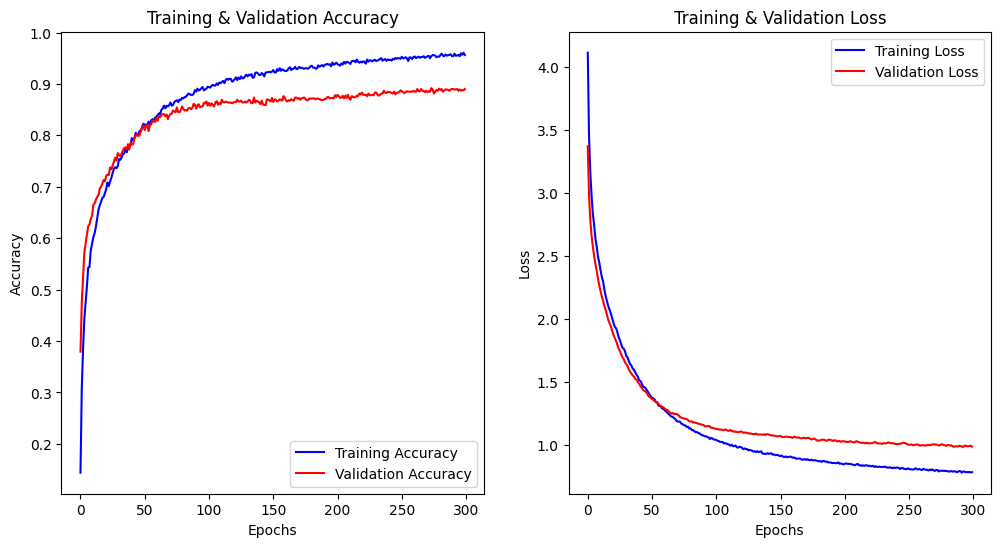

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the datasets
train_data = pd.read_excel("Training_Datasets.xlsx")
test_data = pd.read_excel("Testing_Datasets.xlsx")

# Preprocessing function
def preprocess_data(train_df, test_df):
    for df in [train_df, test_df]:
        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

    tfidf = TfidfVectorizer(max_features=300)
    tfidf_train = tfidf.fit_transform(train_df['Noted'].fillna('')).toarray()
    tfidf_test = tfidf.transform(test_df['Noted'].fillna('')).toarray()

    tfidf_train_df = pd.DataFrame(tfidf_train, columns=[f"TFIDF_{i}" for i in range(tfidf_train.shape[1])])
    tfidf_test_df = pd.DataFrame(tfidf_test, columns=[f"TFIDF_{i}" for i in range(tfidf_test.shape[1])])

    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    categorical_train = ohe.fit_transform(train_df[['Transaction Type', 'Payment Method', 'Location']])
    categorical_test = ohe.transform(test_df[['Transaction Type', 'Payment Method', 'Location']])

    categorical_columns = ohe.get_feature_names_out(['Transaction Type', 'Payment Method', 'Location'])
    categorical_train_df = pd.DataFrame(categorical_train, columns=categorical_columns)
    categorical_test_df = pd.DataFrame(categorical_test, columns=categorical_columns)

    numerical_features = ['Amount', 'Year', 'Month', 'DayOfWeek', 'IsWeekend']
    numerical_train = train_df[numerical_features]
    numerical_test = test_df[numerical_features]

    train_combined = pd.concat([numerical_train, categorical_train_df, tfidf_train_df], axis=1)
    test_combined = pd.concat([numerical_test, categorical_test_df, tfidf_test_df], axis=1)

    return train_combined, test_combined

# Preprocess the datasets
X_train_full, X_test_full = preprocess_data(train_data, test_data)

# Stratified split for balanced training and validation sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_idx, val_idx in split.split(X_train_full, train_data['Category']):
    X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_train, y_val = train_data['Category'].iloc[train_idx], train_data['Category'].iloc[val_idx]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_full)

# Encode the target variable
le_category = LabelEncoder()
y_train = le_category.fit_transform(y_train)
y_val = le_category.transform(y_val)
y_test = le_category.transform(test_data['Category'])

y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_val_onehot = tf.keras.utils.to_categorical(y_val)
y_test_onehot = tf.keras.utils.to_categorical(y_test)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Define the model
model = Sequential([
    Dense(256, activation='relu', kernel_regularizer=l2(0.002), input_dim=X_train_scaled.shape[1]),
    BatchNormalization(),
    Dropout(0.3),  # Increased dropout
    Dense(128, activation='relu', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    Dropout(0.2),  # Retain smaller dropout for deeper layers
    Dense(y_train_onehot.shape[1], activation='softmax')
])

# Adjusted learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0003,  # Lower initial learning rate
    decay_steps=1000,
    decay_rate=0.96
)

# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_scaled, y_train_onehot,
    epochs=300,
    batch_size=64,
    validation_data=(X_val_scaled, y_val_onehot),
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_onehot, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'b-', label='Training Loss')
plt.plot(history.history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
file_path = 'Training_Datasets.xlsx'
df = pd.read_excel(file_path)
category_counts = df['Category'].value_counts()

category_counts

,count
Category,
GROCERY,478
APPAREL,478
BEAUTY,478
GROCERIES,478
SUBSCRIPTION,478
DRINKS,478
FESTIVALS,478
TRANSPORTATION,478
HOUSEHOLD,478


In [ ]:
file_path = 'Testing_Datasets.xlsx'
df = pd.read_excel(file_path)
category_counts = df['Category'].value_counts()

category_counts

,count
Category,
FAMILY,120
UTILITIES,120
EDUCATION,120
FOOD,120
OTHER,120
HEALTH,120
FOOD & DINING,120
BEAUTY,119
TRANSPORTATION,119


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.1665 - loss: 3.0729 - val_accuracy: 0.3891 - val_loss: 2.3211
Epoch 2/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3569 - loss: 2.4158 - val_accuracy: 0.4572 - val_loss: 2.1125
Epoch 3/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4335 - loss: 2.1469 - val_accuracy: 0.4833 - val_loss: 1.9813
Epoch 4/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4519 - loss: 2.0401 - val_accuracy: 0.5134 - val_loss: 1.8775
Epoch 5/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4741 - loss: 1.9207 - val_accuracy: 0.5356 - val_loss: 1.7768
Epoch 6/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5083 - loss: 1.8342 - val_accuracy: 0.5598 - val_loss: 1.7083
Epoch 7/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5124 - loss: 1.7833 - val_accuracy: 0.5749 - val_loss: 1.6341
Epoch 8/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5404 - loss: 1.7132 - val_accu

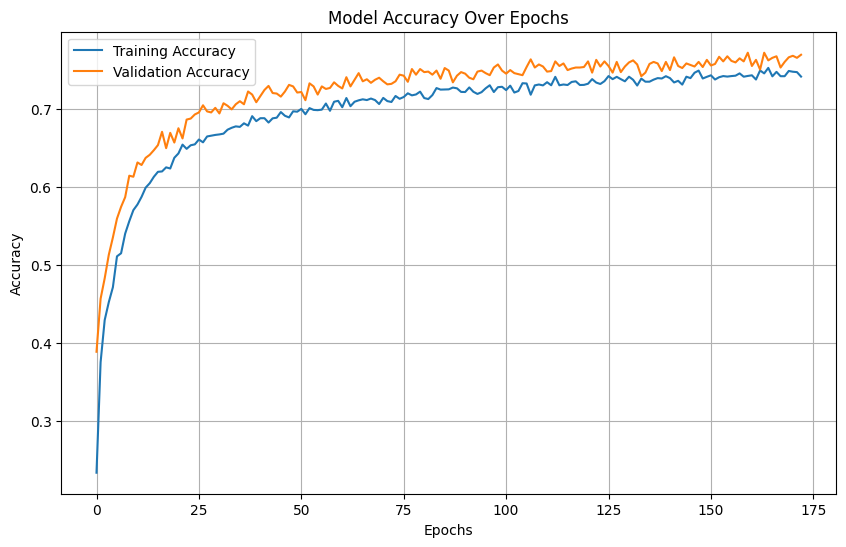

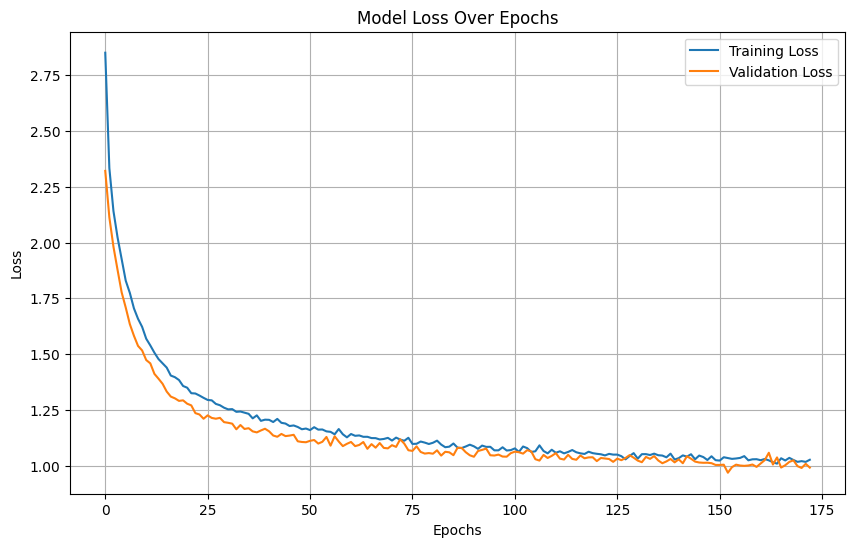

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
train_data = pd.read_excel("Training_Datasets.xlsx")
test_data = pd.read_excel("Testing_Datasets.xlsx")

# Feature Engineering
def preprocess_data_aligned(train_df, test_df):
    # Extract date components
    for df in [train_df, test_df]:
        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['DayOfWeek'] = df['Date'].dt.dayofweek

    # Transform textual features using TF-IDF
    tfidf = TfidfVectorizer(max_features=100)
    tfidf_train = tfidf.fit_transform(train_df['Noted'].fillna('')).toarray()
    tfidf_test = tfidf.transform(test_df['Noted'].fillna('')).toarray()

    tfidf_train_df = pd.DataFrame(tfidf_train, columns=[f"TFIDF_{i}" for i in range(tfidf_train.shape[1])])
    tfidf_test_df = pd.DataFrame(tfidf_test, columns=[f"TFIDF_{i}" for i in range(tfidf_test.shape[1])])

    # One-hot encode categorical columns
    categorical_train = pd.get_dummies(train_df[['Transaction Type', 'Payment Method']])
    categorical_test = pd.get_dummies(test_df[['Transaction Type', 'Payment Method']])

    # Align columns
    categorical_train, categorical_test = categorical_train.align(categorical_test, join='outer', axis=1, fill_value=0)

    # Combine features
    numerical_train = train_df[['Amount', 'Year', 'Month', 'DayOfWeek']]
    numerical_test = test_df[['Amount', 'Year', 'Month', 'DayOfWeek']]

    train_combined = pd.concat([numerical_train, categorical_train, tfidf_train_df], axis=1)
    test_combined = pd.concat([numerical_test, categorical_test, tfidf_test_df], axis=1)

    return train_combined, test_combined

# Preprocess training and testing datasets
X_train_full, X_test_full = preprocess_data_aligned(train_data, test_data)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# Encode target variable
le_category = LabelEncoder()
y_train = le_category.fit_transform(train_data['Category'])
y_test = le_category.transform(test_data['Category'])

# Convert target to one-hot encoding
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Step 1: Add Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Step 2: Adjust Regularization
# Increase dropout rates and add L2 regularization
model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),  # Increased dropout rate
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),  # Increased dropout rate
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(y_train_onehot.shape[1], activation='softmax')
])

# Step 3: Compile the model with the same optimizer and metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Balance the Dataset
# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# Step 5: Simplify the Model Architecture (if necessary)
# This was done by not adding additional layers or complex structures.

# Step 6: Train the Model with Early Stopping and Class Weights
history = model.fit(
    X_train_scaled, y_train_onehot,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict,  # Apply class weights
    callbacks=[early_stopping],  # Apply early stopping
    verbose=1
)

# Step 7: Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_onehot, verbose=0)

# Print results
print(f"Test Accuracy: {test_accuracy:.2f}")

# Step 8: Plot Training and Validation Metrics
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()S
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# **Define**

Coba dulu

In [ ]:
'''
# Load the dataset
training_data = pd.read_excel("Training_Datasets.xlsx")

# Preprocessing: Encode categorical columns and scale numerical features
features = training_data.drop(columns=["Date", "Category", "Transaction ID", "Noted"])
target = training_data["Category"]

# Encode categorical features and target
encoder = LabelEncoder()
encoded_features = features.apply(lambda col: encoder.fit_transform(col) if col.dtypes == "object" else col)
encoded_target = encoder.fit_transform(target)

# Scale numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(encoded_features)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, encoded_target, test_size=0.2, random_state=42)
'''

# Step 1: Load the Dataset
training_data = pd.read_excel("Balanced_Household_Transactiond.xlsx")

# Step 2: Flatten Subcategory and Category
training_data['Label'] = training_data['Category'] + " - " + training_data['Sub Category']

# Step 3: Data Preprocessing
# Select features and the new combined target
features = training_data.drop(columns=['Date', 'Category', 'Sub Category', 'Transaction ID', 'Noted', 'Label'])
target = training_data['Label']

# Encode categorical features and target
encoder = LabelEncoder()
encoded_features = features.apply(lambda col: encoder.fit_transform(col) if col.dtypes == 'object' else col)
encoded_target = encoder.fit_transform(target)

# Scale numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(encoded_features)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, encoded_target, test_size=0.2, random_state=42)

# **Build Neural Network**

Coba Dulu

In [ ]:
# Define the neural network model
nn_model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.5),  # Dropout for regularization
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(32, activation="relu"),
    Dropout(0.4),
    Dense(16, activation="relu"),
    Dropout(0.4),
    Dense(len(encoder.classes_), activation="softmax")  # Output layer matches the number of classes
])

# Compile the model
nn_model.compile(optimizer="adam",
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

nn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 50)                  │             850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,610 (49.26 KB)

 Trainable params: 12,610 (49.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
'''
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(10,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()
'''

"\nmodel = tf.keras.Sequential([\n    tf.keras.layers.Dense(64, activation='relu', input_shape=(10,)),\n    tf.keras.layers.Dropout(0.2),\n    tf.keras.layers.Dense(32, activation='relu'),\n    tf.keras.layers.Dropout(0.2),\n    tf.keras.layers.Dense(16, activation='relu'),\n    tf.keras.layers.Dense(1, activation='sigmoid')\n])\n\nmodel.compile(\n    optimizer='adam',\n    loss='binary_crossentropy',\n    metrics=['accuracy']\n)\n\nmodel.summary()\n"

# **Training**

Coba Dulu

In [ ]:
'''
# Set accuracy threshold for early stopping
accuracy_threshold = 0.95  # Stop when validation accuracy reaches 95%
early_stopping_callback = CustomEarlyStopping(accuracy_threshold)

# Train the model with the custom early stopping callback
history = nn_model.fit(X_train, y_train,
                       validation_data=(X_test, y_test),
                       epochs=1000,  # Maximum epochs
                       batch_size=32,
                       verbose=1,
                       callbacks=[early_stopping_callback])

# Evaluate the model
test_loss, test_accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy}")
'''

# Define the learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  # Reduce learning rate by half
    patience=5,  # Trigger after 5 epochs of no improvement
    min_lr=1e-6,  # Minimum learning rate
    verbose=1
)

# Set accuracy threshold for early stopping
accuracy_threshold = 0.95  # Stop when validation accuracy reaches 95%
early_stopping_callback = CustomEarlyStopping(accuracy_threshold)

# Train the model with early stopping and learning rate scheduler
history = nn_model.fit(X_train, y_train,
                       validation_data=(X_test, y_test),
                       epochs=1000,  # Maximum epochs
                       batch_size=32,
                       verbose=1,
                       callbacks=[early_stopping_callback, lr_scheduler])

# Evaluate the model
test_loss, test_accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/1000
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0443 - loss: 3.8349 - val_accuracy: 0.1723 - val_loss: 3.4257 - learning_rate: 0.0010
Epoch 2/1000
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1102 - loss: 3.4857 - val_accuracy: 0.2608 - val_loss: 3.0213 - learning_rate: 0.0010
Epoch 3/1000
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1731 - loss: 3.2321 - val_accuracy: 0.2724 - val_loss: 2.8344 - learning_rate: 0.0010
Epoch 4/1000
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2042 - loss: 3.0564 - val_accuracy: 0.3143 - val_loss: 2.6836 - learning_rate: 0.0010
Epoch 5/1000
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2302 - loss: 2.9944 - val_accuracy: 0.3149 - val_loss: 2.6121 - learning_rate: 0.0010
Epoch 6/1000
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2325 - loss: 2.8677 - val_accuracy: 0.3690 - val_loss: 2.5459 - learning_rate: 0.0010
Epoch 7/1000
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2693 - l

Coba Dulu

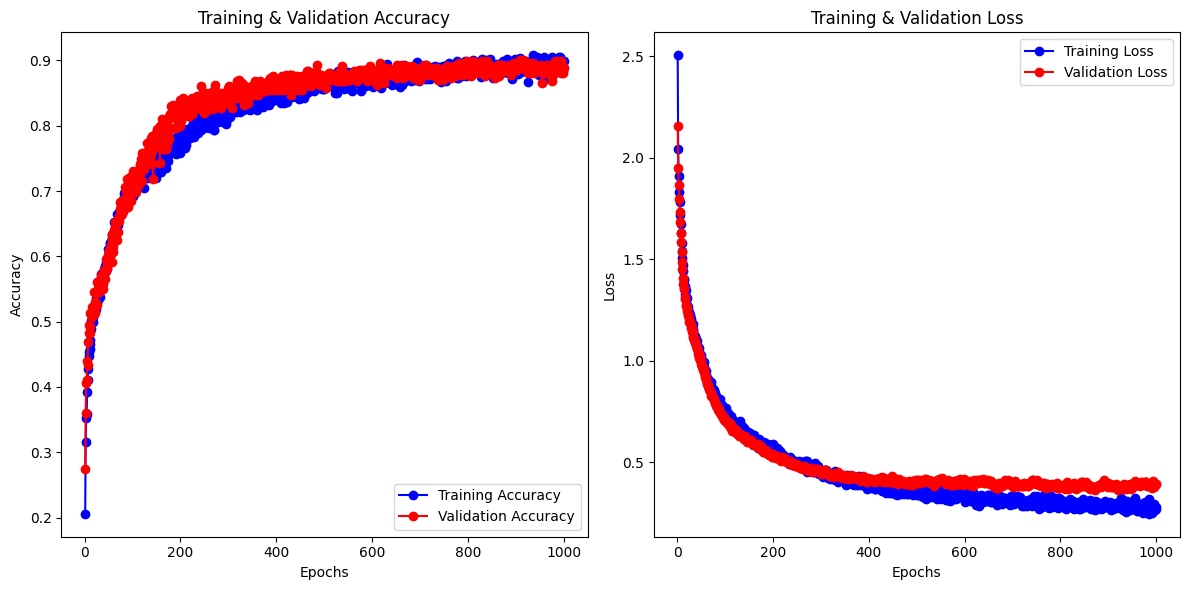

In [ ]:
'''
# After training, plot training & validation accuracy and loss
def plot_training_history(history):
    # Extract metrics from the history object
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(accuracy) + 1)

    # Plot training & validation accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the function after training
plot_training_history(history)
'''

# Plot the training and validation accuracy and loss
def plot_training_history(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, "bo-", label="Training Accuracy")
    plt.plot(epochs, val_accuracy, "ro-", label="Validation Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "bo-", label="Training Loss")
    plt.plot(epochs, val_loss, "ro-", label="Validation Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the history
plot_training_history(history)

Train , evaluasi

In [ ]:
# history = model.fit(train_batches, epochs=10, validation_data=validation_batches)

# Save Model and Convert to TFLite

In [ ]:
# Save the model in HDF5 format
model_path = "optimized_neural_network_model_with_early_stopping.h5"
nn_model.save(model_path, save_format='tf')
print(f"Model saved at: {model_path}")

# Load the model from HDF5
loaded_model = tf.keras.models.load_model(model_path)

# Convert the loaded model to TensorFlow Lite
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = tflite_converter.convert()

# Save the TFLite model to a file
tflite_model_path = "optimized_neural_network_model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"TFLite model saved at: {tflite_model_path}")

Model saved at: optimized_neural_network_model_with_early_stopping.h5


OSError: SavedModel file does not exist at: optimized_neural_network_model_with_early_stopping.h5/{saved_model.pbtxt|saved_model.pb}

# **TFLiteConverter**

In [ ]:
model.save('saved_model')
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

with open('saved_model.tflite', 'wb') as f:
    f.write(tflite_model)

# **Download**